# <center> 作业二 Food-11 </center>
by Hyr1sky_He

_为了提高任务效率，本ipynb中不再细化每个步骤的操作过程，仅记录重要思路及核心方法，Task题目解答将在实验报告中给出_

In [1]:
import numpy as np
import pandas as pd
import torch
import time
import os
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm.auto import tqdm
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the train model
"""
model = classifier().to(device)
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)
model.eval()

print(model)
"""

"\nmodel = classifier().to(device)\nstate_dict = torch.load('model.pth')\nmodel.load_state_dict(state_dict)\nmodel.eval()\n\nprint(model)\n"

## 数据加载

In [2]:
# 读入数据
data_dir = Path('../Assignment2_dataset/food-11')
train_dir = data_dir / 'training'
val_dir = data_dir / 'validation'
test_dir = data_dir / 'testing'

def readfile(path,own_label):#后面的参数用来区分训练集和测试集
    image_dir = sorted(os.listdir(path)) #对path下的文件进行排序后输出
    x = np.zeros((len(image_dir),128,128,3),dtype=np.uint8) #初始化，用来保存训练数据
    y = np.zeros((len(image_dir)),dtype=np.uint8) #初始化，用来保存label
    for i,file in enumerate(image_dir): #循环，将图片信息保存到x,y
        # 读取image
        img = Image.open(os.path.join(path,file))
        # 将image Resize成(128, 128)
        x[i,:,:] = img.resize((128,128))
        if own_label: #此处来判断是训练还是测试，True为训练，False为测试
            y[i] = int(file.split("_")[0]) #如果是True,则给y赋值，文件名的第一个数
    if own_label:#有label，返回x,y
        return x,y
    else:#无label，返回x
        return x

In [6]:
# Load the dataset.
#分别读取训练、验证和测试的数据，保存到相应的变量里
train_x, train_y = readfile(train_dir, True)
print("Size of training data = {}".format(len(train_x)))
val_x ,val_y = readfile(val_dir, True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(test_dir, False)
print("Size of Testing data = {}".format(len(test_x)))

"""
train_set = DatasetFolder(train_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=train_transform)
valid_set = DatasetFolder(val_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)
unlabeled_set = DatasetFolder(, loader=lambda x: Image.open(x), extensions="jpg", transform=train_transform)
test_set = DatasetFolder(test_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)
"""
# Construct data loaders.
"""
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
"""

Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


'\ntrain_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)\nvalid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)\ntest_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)\n'

## 数据读入与处理的函数

In [36]:
mean = np.mean([np.array(img, dtype = np.float32) / 255.0 for img in train_x] +
               [np.array(img, dtype = np.float32) / 255.0 for img in val_x], axis=(0, 1, 2))
std = np.std([np.array(img, dtype = np.float32) / 255.0 for img in train_x] + 
             [np.array(img, dtype = np.float32) / 255.0 for img in val_x], axis=(0, 1, 2))

print("Mean of Train Data = {}".format(mean))
print("Std of Train Data = {}".format(std))

Mean of Train Data = [0.07701565 0.07701565 0.07701565]
Std of Train Data = [0.27751693 0.27751693 0.27751693]


## 关于Transform
[torchvision.transforms 常用方法解析（含图例代码以及参数解释）](https://blog.csdn.net/weixin_42426841/article/details/129903800)

In [41]:
# transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.5, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 128
# 采用分批次训练（加快参数更新速度），设置好我们的batch_size大小

In [20]:
# 数据集类处理
class ImgDataset(Dataset):
    def __init__(self,x,y = None,transform = None):
        self.x = x
        self.y = y
        if y is not None: #label必须为长整形
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        X = self.x[index]
        if self.transform is not None:#判断是否有图像变换
            X = self.transform(X) #有，则取变换后的X
        if self.y is not None: #判断是否有y(label)
            Y = self.y[index]
            return X,Y #有，则返回X,Y
        else:
            return X #无y(label),返回X

## 展示图片与变换

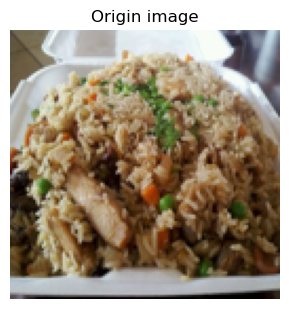

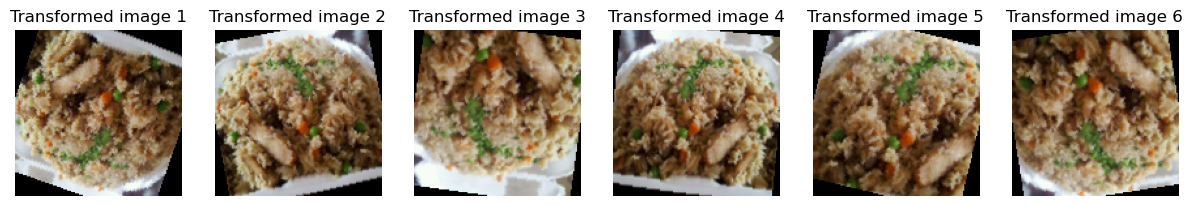

In [42]:
TFM_N = 6

# 随机取出一张图片，显示原图和变换后的图片
idx = np.random.randint(0, len(train_x))
origin_img = train_x[idx]
plt.figure(figsize=(15, 3.5))
plt.title('Origin image')
plt.imshow(origin_img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 3.5))
for i in range(TFM_N):
    tfm_img = train_transform(origin_img)
    plt.subplot(1, TFM_N, i+1)
    plt.title(f"Transformed image {i + 1}")
    plt.imshow(tfm_img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

## 数据读入

In [62]:
train_set = ImgDataset(train_x,train_y,train_transform)
val_set = ImgDataset(val_x,val_y,test_transform)
test_set = ImgDataset(test_x,None,test_transform)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

## 做一个小的数据切片来实验

In [64]:
"""
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347
"""
# 随机取出1000张训练集数据组成新的训练集
MINISIZE_1 = 1000
MINISIZE_2 = 300

random_sample_1 = np.random.randint(0, len(train_set), size=MINISIZE_1)
random_sample_2 = np.random.randint(0, len(train_set), size=MINISIZE_2)
train_miniset = Subset(train_set, random_sample_1)
val_miniset = Subset(val_set, random_sample_2)
test_miniset = Subset(test_set, random_sample_2)

"""
minitrain_x = train_miniset.dataset.x[train_miniset.indices]
minitrain_y = train_miniset.dataset.y[train_miniset.indices]
minival_x = val_miniset.dataset.x[val_miniset.indices]
minival_y = val_miniset.dataset.y[val_miniset.indices]
minitest_x = test_miniset.dataset.x[test_miniset.indices]
"""

print("Size of mini training data = {}".format(len(train_miniset)))
print("Size of mini validation data = {}".format(len(val_miniset)))
print("Size of mini testing data = {}".format(len(test_miniset)))

minitrain_loader = DataLoader(train_miniset, batch_size = batch_size, shuffle = True)
minival_loader = DataLoader(val_miniset, batch_size = batch_size, shuffle = False)
minitest_loader = DataLoader(test_miniset, batch_size = batch_size, shuffle = False)

Size of mini training data = 1000
Size of mini validation data = 300
Size of mini testing data = 300


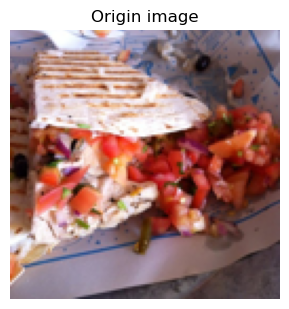

In [65]:
# 随机查看minitrain数据集中的图片
idx = np.random.randint(0, len(train_miniset))
origin_img = train_miniset.dataset.x[idx]
plt.figure(figsize=(15, 3.5))
plt.title('Origin image')
plt.imshow(origin_img)
plt.axis('off')
plt.show()

In [56]:
# CNN
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        #
        out = self.CNN(x)

        return out

In [58]:
print("CUDA Available:",torch.cuda.is_available())

CUDA Available: False


## Train

In [67]:
#训练过程
model = Classifier()
# 实例化，若有显卡则使用显卡
if torch.cuda.is_available():
    model.cuda()
else: 
    model.cpu()

loss = nn.CrossEntropyLoss() #损失函数
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)#优化函数
num_epoch = 30 #训练次数

#开始训练
for epoch in range(num_epoch):
    #初始化一些数值
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()#启用 BatchNormalization 和 Dropout
    for i,data in enumerate(minitrain_loader):
        optimizer.zero_grad() #梯度归零
        train_pred = model(data[0].cuda()) #前馈 !!!cuda
        batch_loss = loss(train_pred,data[1].cuda()) #损失计算 !!!!!
        batch_loss.backward() #反馈
        optimizer.step() #优化

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis=1)==data[1].numpy())#计算准确率，得到的数和label是否相等
        train_loss += batch_loss.item() #损失累加

    #在验证集上测试准确率
    model.eval()#不启用 BatchNormalization 和 Dropout
    with torch.no_grad():#不求导，节省内存
        for i,data in enumerate(minival_loader):
            val_pred = model(data[0].cuda()) #前馈 !!!!
            batch_loss = loss(val_pred,data[1].cuda()) #计算损失 !!!!!!

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1) == data[1].numpy())#计算准确率
            val_loss += batch_loss.item()#损失累加
        #打印输出
        print('[%03d/%03d] %2.2f sec(s) Train Acc:%3.6f Loss:%3.6f | Val Acc:%3.6f loss:%3.6f' %\
                (epoch + 1,num_epoch,time.time()-epoch_start_time,\
                train_acc/train_miniset.__len__(),train_loss/train_miniset.__len__(),val_acc/val_miniset.__len__(),val_loss/val_miniset.__len__()))

AssertionError: Torch not compiled with CUDA enabled

## 合并

In [ ]:
train_val_x = np.concatenate((train_x,val_x),axis=0) #合并训练集和验证集的X
train_val_y = np.concatenate((train_y,val_y),axis=0) #合并训练集和验证集的Y
train_val_set = ImgDataset(train_val_x,train_val_y,train_transform) #实例化
train_val_loader = DataLoader(train_val_set,batch_size=batch_size,shuffle=True) #载入数据

model_best = Classifier().cuda() #此处的Classifier应该是你自己调整后，网络结构最好的网络
loss = nn.CrossEntropyLoss() #损失函数
optimizer = torch.optim.Adam(model_best.parameters(),lr=0.001) #优化函数
num_epoch = 30 #训练次数

#开始训练
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i,data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred,data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    #输出结果
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))